# Armenia Data Setup

In [ ]:
# --- System and file handling ---
import os
import pandas as pd
import imageio

# --- Numerical and array operations ---
import numpy as np

# --- Raster handling ---
import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds

# --- Geo-spatial handling ---
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Plotting ---
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import cm

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
from pathlib import Path

In [2]:
# --- Path to SPEI raster data ---
data_dir = 'SPEI_Data'

# --- Find all folders starting with 'sem01' ---
folders = [
    f for f in os.listdir(data_dir) 
    if f.startswith('spe03') and os.path.isdir(os.path.join(data_dir, f))
]

records = []

# --- Loop through folders and load all .tif files ---
for folder in folders:
    folder_path = os.path.join(data_dir, folder)
    for file in os.listdir(folder_path):
        if file.endswith('.tif'):
            file_path = os.path.join(folder_path, file)
            with rasterio.open(file_path) as src:
                img = src.read(1)  # Read the first band
                records.append({
                    'folder': folder,
                    'file': file,
                    'data': img
                })

# --- Create a DataFrame with all rasters ---
df_tiffs = pd.DataFrame(records)


In [3]:
df_tiffs

,folder,file,data
0,spe03_m_gdo_20000101_20001221_t,spe03_m_gdo_20000101_t_100_z01.tif,"[[0.9837388396263123, 0.9840770363807678, 0.98..."
1,spe03_m_gdo_20000101_20001221_t,spe03_m_gdo_20000111_t_100_z01.tif,"[[0.5839343070983887, 0.5843697786331177, 0.58..."
2,spe03_m_gdo_20000101_20001221_t,spe03_m_gdo_20000121_t_100_z01.tif,"[[0.40013134479522705, 0.40064290165901184, 0...."
3,spe03_m_gdo_20000101_20001221_t,spe03_m_gdo_20000201_t_100_z01.tif,"[[-0.00359622435644269, -0.002852226374670863,..."
4,spe03_m_gdo_20000101_20001221_t,spe03_m_gdo_20000211_t_100_z01.tif,"[[-0.4469110369682312, -0.44590020179748535, -..."
...,...,...,...
925,spe03_m_gdo_20250101_20251021_t,spe03_m_gdo_20250911_t_100_z02.tif,"[[-0.43388301134109497, -0.4329618215560913, -..."
926,spe03_m_gdo_20250101_20251021_t,spe03_m_gdo_20250921_t_100_z02.tif,"[[-0.4672435522079468, -0.4664509892463684, -0..."
927,spe03_m_gdo_20250101_20251021_t,spe03_m_gdo_20251001_t_100_z01.tif,"[[0.18090546131134033, 0.18149420619010925, 0...."
928,spe03_m_gdo_20250101_20251021_t,spe03_m_gdo_20251011_t_100_z01.tif,"[[0.6585487127304077, 0.6585125923156738, 0.65..."


### Only plot the Data

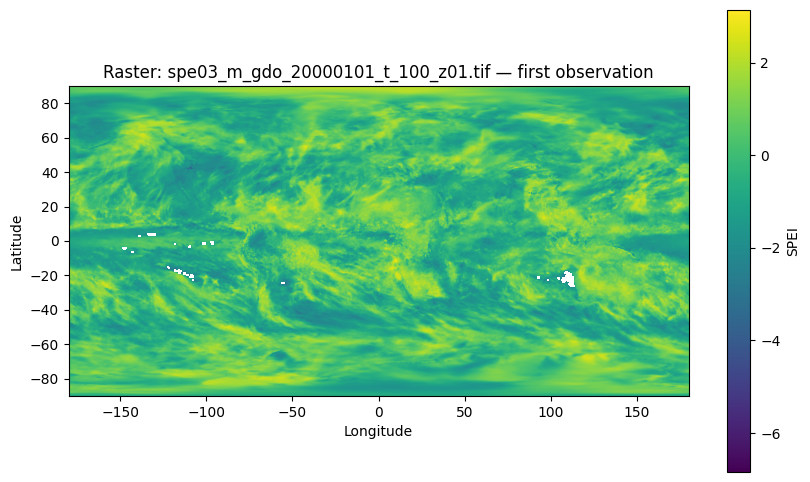

Raster geographic bounds (minx, maxx, miny, maxy): [-180.0, 180.0, -90.0, 90.0]


In [5]:
# --- Pick the first raster observation ---
first_row = df_tiffs.iloc[0]
img = first_row['data']
folder = first_row['folder']
file = first_row['file']
file_path = os.path.join('SPEI_Data', folder, file)


# --- Reopen raster to get transform and CRS ---
with rasterio.open(file_path) as src:
    transform = src.transform
    crs = src.crs
    # Compute geographic bounds
    h, w = src.height, src.width
    minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
    extent = [minx, maxx, miny, maxy]

# --- Mask invalid values ---
masked = np.ma.masked_invalid(img)

# --- Plot raster ---
plt.figure(figsize=(10, 6))
plt.imshow(masked, origin='upper', extent=extent, cmap='viridis')
plt.colorbar(label='SPEI')
plt.title(f"Raster: {file} — first observation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# --- Print raster extent info ---
print("Raster geographic bounds (minx, maxx, miny, maxy):", extent)


In [6]:
import os
import rasterio
import geopandas as gpd

def inspect_tif_crs(fp, geojson_path=None):
    """
    Inspect CRS and metadata of a raster file, optionally comparing it to a GeoJSON file.

    Parameters
    ----------
    fp : str
        Path to the raster (.tif) file.
    geojson_path : str, optional
        Path to a GeoJSON file to compare CRS and extent.
    """
    if not os.path.exists(fp):
        print(f"File not found: {fp}")
        return

    with rasterio.open(fp) as src:
        crs = src.crs
        try:
            epsg = crs.to_epsg() if crs else None
        except Exception:
            epsg = None

        print("File:", fp)
        print("Driver:", src.driver)
        print("Band count:", src.count)
        print("Width x Height:", src.width, "x", src.height)
        print("Dtype(s):", src.dtypes)
        print("Nodata:", src.nodata)
        print("Transform:", src.transform)
        print("Bounds:", src.bounds)

        if crs is None:
            print("CRS: None")
            return

        print("CRS (rasterio):", crs)
        if epsg is not None:
            print("Detected EPSG code:", epsg)
        else:
            try:
                print("CRS as string:", crs.to_string())
            except Exception:
                pass

        # Interpret CRS
        if epsg == 3035:
            print("This raster is in EPSG:3035 (ETRS89 / LAEA Europe).")
        elif epsg == 4326:
            print("This raster is in EPSG:4326 (WGS84 geographic coordinates - degrees).")
        else:
            try:
                if crs.is_projected:
                    print("CRS appears to be projected (units likely in metres).")
                elif crs.is_geographic:
                    print("CRS appears to be geographic (units in degrees).")
            except Exception:
                pass
            print("If EPSG is None above, consider inspecting the CRS WKT or using pyproj to identify it.")

        # resolution (pixel size)
        res_x = abs(src.transform.a)
        res_y = abs(src.transform.e)
        print(f"Approx. pixel size: {res_x} x {res_y} (units of CRS)")

        # compare with districts GeoDataFrame if available
        try:
            print("\nComparing with `districts` GeoDataFrame:")
            print("districts.crs:", districts.crs)
            if districts.crs is not None:
                same = (districts.crs == crs) or (
                    getattr(districts.crs, 'to_epsg', lambda: None)() == epsg
                )
                print("→ Same CRS as raster?", same)
        except NameError:
            pass

        # compare with GeoJSON if provided
        if geojson_path is not None:
            if os.path.exists(geojson_path):
                print(f"\nComparing with GeoJSON file: {geojson_path}")
                gdf = gpd.read_file(geojson_path)

                print("GeoJSON CRS:", gdf.crs)
                same_crs = (gdf.crs == crs) or (
                    getattr(gdf.crs, 'to_epsg', lambda: None)() == epsg
                )
                print("→ Same CRS as raster?", same_crs)

                # Compare spatial overlap (bounding boxes)
                raster_bounds = src.bounds
                geojson_bounds = gdf.total_bounds  # minx, miny, maxx, maxy

                print("Raster bounds:", raster_bounds)
                print("GeoJSON bounds:", geojson_bounds)

                # Check if they overlap at all
                overlap = not (
                    geojson_bounds[2] < raster_bounds.left or
                    geojson_bounds[0] > raster_bounds.right or
                    geojson_bounds[3] < raster_bounds.bottom or
                    geojson_bounds[1] > raster_bounds.top
                )
                print("→ Do raster and GeoJSON extents overlap?", overlap)
            else:
                print(f"\nGeoJSON path not found: {geojson_path}")


# Example usage:
inspect_tif_crs(file_path, geojson_path="armenia_shapefile/am.json")


File: SPEI_Data\spe03_m_gdo_20000101_20001221_t\spe03_m_gdo_20000101_t_100_z01.tif
Driver: GTiff
Band count: 1
Width x Height: 1440 x 720
Dtype(s): ('float64',)
Nodata: nan
Transform: | 0.25, 0.00,-180.00|
| 0.00,-0.25, 90.00|
| 0.00, 0.00, 1.00|
Bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
CRS (rasterio): EPSG:4326
Detected EPSG code: 4326
This raster is in EPSG:4326 (WGS84 geographic coordinates - degrees).
Approx. pixel size: 0.25 x 0.25 (units of CRS)

Comparing with `districts` GeoDataFrame:

Comparing with GeoJSON file: armenia_shapefile/am.json
GeoJSON CRS: EPSG:4326
→ Same CRS as raster? True
Raster bounds: BoundingBox(left=-180.0, bottom=-90.0, right=180.0, top=90.0)
GeoJSON bounds: [43.43629398 38.86370114 46.60261234 41.29045244]
→ Do raster and GeoJSON extents overlap? True


### Plot over Europe

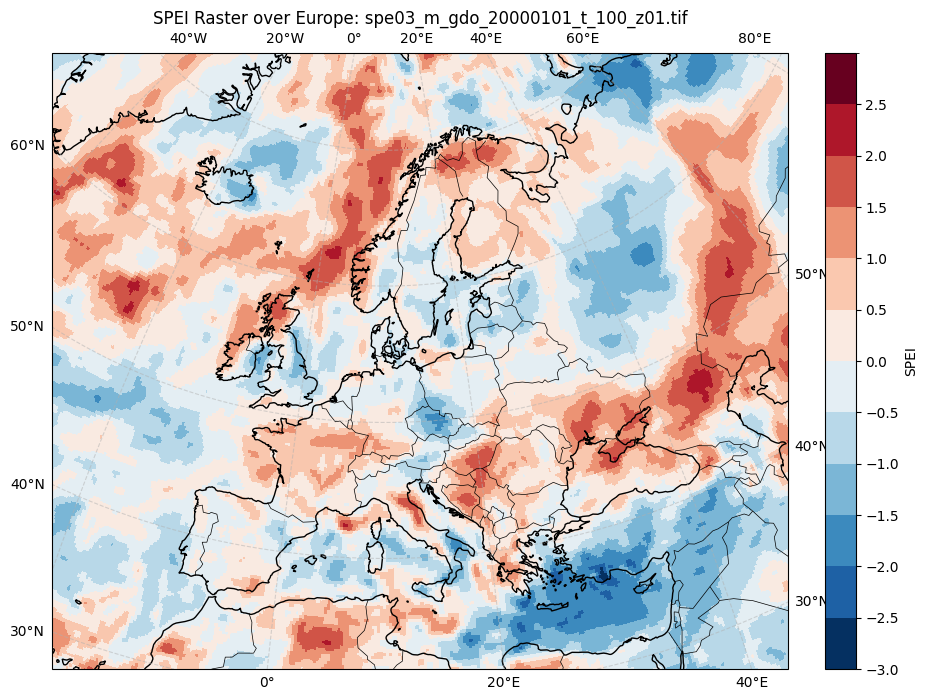

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from matplotlib import colormaps
import rasterio
import numpy as np
import os

# --- Colormap and normalization ---
cmap_name = 'RdBu_r'
cmap = colormaps[cmap_name].copy()
cmap.set_bad(color='lightgray')

bounds = np.linspace(-3, 3, 13)
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# Pick a raster file
row = df_tiffs.iloc[0]
file_path = os.path.join('SPEI_Data', row['folder'], row['file'])

# Reopen the tif to get affine transform/crs
with rasterio.open(file_path) as src:
    img = src.read(1)
    transform = src.transform
    crs = src.crs

# Mask invalid values (NaNs)
masked = np.ma.masked_invalid(img)

# Compute raster extent
h, w = img.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
extent = [minx, maxx, miny, maxy]

# Use EPSG:3035 projection for the map
map_crs = ccrs.epsg(3035)

# Plot in EPSG:3035 but raster transform is PlateCarree (EPSG:4326)
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'projection': map_crs})

im = ax.imshow(masked, origin='upper', extent=extent, transform=ccrs.PlateCarree(),
               cmap=cmap, norm=norm)

# Zoom to Europe in EPSG:3035
eu_extent_3035 = [1600000, 7600000, 750000, 6000000]  # in meters
ax.set_extent(eu_extent_3035, crs=map_crs)

# Add features
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.OCEAN, facecolor='lightblue', alpha=0.2)
ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)

# Colorbar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, ticks=bounds[:-1])
cbar.set_label('SPEI')

ax.set_title(f"SPEI Raster over Europe: {row['file']}")
plt.show()


# Go to Armenia

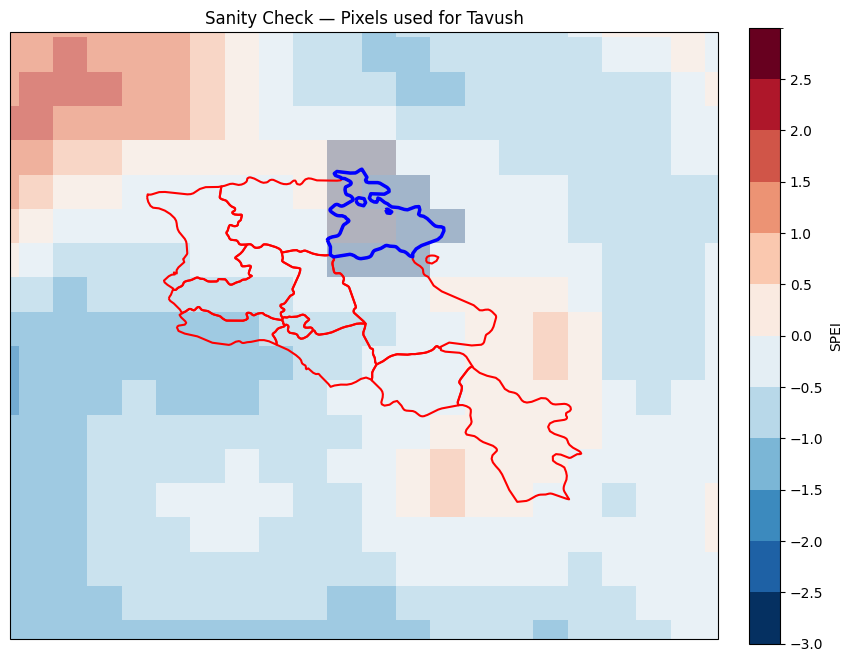

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import geometry_mask
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.colors import BoundaryNorm
from matplotlib import colormaps
import rasterio.transform

# --- Colormap and normalization ---
cmap_name = 'RdBu_r'
cmap = colormaps[cmap_name].copy()
cmap.set_bad(color='lightgray')
bounds = np.linspace(-3, 3, 13)
norm = BoundaryNorm(bounds, ncolors=cmap.N)

# --- Pick raster ---
row = df_tiffs.iloc[0]
file_path = os.path.join("SPEI_Data", row["folder"], row["file"])

with rasterio.open(file_path) as src:
    img = src.read(1)
    transform = src.transform
    crs = src.crs

masked = np.ma.masked_invalid(img)
h, w = img.shape
minx, miny, maxx, maxy = rasterio.transform.array_bounds(h, w, transform)
extent = [minx, maxx, miny, maxy]

# --- Load Armenia districts ---
districts_fp = "armenia_shapefile/am.json"
districts = gpd.read_file(districts_fp).to_crs(crs)

# --- Select one district (for example, Erevan) ---
district_name = "Tavush"
district = districts[districts["name"] == district_name].iloc[0]
geom = [district.geometry]

# --- Create mask (True for outside district) ---
mask = geometry_mask(
    geom,
    out_shape=masked.shape,
    transform=transform,
    invert=True, 
     all_touched=True  # True = inside polygon
)

# --- Visualization ---
map_crs = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": map_crs})

# Base SPEI raster
im = ax.imshow(masked, origin="upper", extent=extent, transform=map_crs,
               cmap=cmap, norm=norm)

# Overlay Armenia borders
districts.boundary.plot(ax=ax, edgecolor="red", linewidth=1.5, transform=map_crs)

# Overlay mask as transparent blue overlay where district pixels are selected
masked_overlay = np.zeros_like(masked, dtype=float)
masked_overlay[mask] = 1  # mark selected pixels
ax.imshow(masked_overlay, origin="upper", extent=extent, transform=map_crs,
           cmap="Blues", alpha=0.3)

# Highlight the specific district outline thicker
gpd.GeoSeries([district.geometry]).boundary.plot(ax=ax, edgecolor="blue", linewidth=2.5, transform=map_crs)

# --- Zoom to Armenia ---
minx, miny, maxx, maxy = districts.total_bounds
ax.set_extent([minx - 1, maxx + 1, miny - 1, maxy + 1], crs=map_crs)

# --- Colorbar ---
cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04, ticks=bounds[:-1])
cbar.set_label("SPEI")

ax.set_title(f"Sanity Check — Pixels used for {district_name}")
plt.show()


# Calculate Distict Averages

In [10]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from tqdm import tqdm  # <-- progress bar

# --- Load Armenia districts ---
districts_fp = "armenia_shapefile/am.json"
districts = gpd.read_file(districts_fp)

# --- Prepare storage for results ---
results = []

base_dir = "SPEI_Data"

# --- List all raster files first ---
all_files = []
for folder in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        if file.endswith(".tif"):
            all_files.append((folder, os.path.join(folder_path, file)))

# --- Loop over all files with tqdm ---
for folder, file_path in tqdm(all_files, desc="Processing raster files"):
    with rasterio.open(file_path) as src:
        img = src.read(1)
        transform = src.transform
        crs = src.crs

        masked = np.ma.masked_invalid(img)
        districts_proj = districts.to_crs(crs)

        for idx, dist in districts_proj.iterrows():
            geom = [dist.geometry]

            mask = rasterize(
                [(dist.geometry, 1)],
                out_shape=masked.shape,
                transform=transform,
                all_touched=True,
                fill=0,
                dtype=np.uint8
            ).astype(bool)

            values = masked[mask]

            mean_value = np.nan
            if values.size > 0:
                mean_value = values.mean()

            results.append({
                "folder": folder,
                "file": os.path.basename(file_path),
                "district": dist["name"],
                "mean_spei": mean_value
            })

# --- Convert to DataFrame ---
df_districts_spei = pd.DataFrame(results)
print(df_districts_spei.head())


Processing raster files: 100%|██████████| 930/930 [02:25<00:00,  6.37it/s]

                            folder                                file  \
0  spe03_m_gdo_20000101_20001221_t  spe03_m_gdo_20000101_t_100_z01.tif   
1  spe03_m_gdo_20000101_20001221_t  spe03_m_gdo_20000101_t_100_z01.tif   
2  spe03_m_gdo_20000101_20001221_t  spe03_m_gdo_20000101_t_100_z01.tif   
3  spe03_m_gdo_20000101_20001221_t  spe03_m_gdo_20000101_t_100_z01.tif   
4  spe03_m_gdo_20000101_20001221_t  spe03_m_gdo_20000101_t_100_z01.tif   

      district  mean_spei  
0       Tavush  -0.074052  
1         Lori  -0.155174  
2       Shirak  -0.408265  
3  Gegharkunik  -0.185340  
4  Vayots Dzor  -0.134853  


In [11]:
df_worker = df_districts_spei.copy()
df_worker['date'] = pd.to_datetime(df_worker['file'].str.extract(r'(\d{8})')[0], format='%Y%m%d')
df_worker.drop(columns=['folder', 'file'], inplace=True)
df_worker.to_csv('drought_data_output/spei3_hf_raw.csv', index=False)